# JIT Parameters and visualization using Pandas
Author: Jørgen S. Dokken

In this chapter, we will explore how to optimize and inspect the integration kernels used in DOLFINx.
As we have seen in the previous demos, dolfinx uses the [Unified form language](https://github.com/FEniCS/ufl/) to describe variational problems.

These descriptions has to be translated in to code for assembling the right and left hand side of the discrete variational problem. 

DOLFINx uses [ffcx](https://github.com/FEniCS/ffcx/) to generate efficient C code assembling the element matrices.
This C code is in turned compiled using [CFFI](https://cffi.readthedocs.io/en/latest/), and we can specify a variety of compile options.

We start by specifying the current directory as the place to place the generated C files, we obtain the current directory using pathlib

In [20]:
from pathlib import Path
cache_dir = f"{str(Path.cwd())}/.cache"
print(f"Directory to put C files in: {cache_dir}")

Directory to put C files in: /home/shared/chapter4/.cache


Next we generate a general function to assemble the mass matrix for a UnitCube. Note that we use `dolfinx.fem.Form` to compile the variational form. For codes using `dolfinx.LinearProblem`, you can supply `jit_parameters` as a keyword argument.

In [28]:
import dolfinx
from mpi4py import MPI
from typing import Dict
import time
import ufl

def compile_form(space:str, degree:int, jit_parameters:Dict):
    N = 10
    mesh = dolfinx.UnitCubeMesh(MPI.COMM_WORLD, N, N, N)
    V = dolfinx.FunctionSpace(mesh, (space, degree))
    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)
    a = ufl.inner(u, v) * ufl.dx
    a_compiled = dolfinx.fem.Form(a, jit_parameters=jit_parameters)
    start = time.time()
    dolfinx.fem.assemble_matrix(a_compiled)
    end = time.time()
    return end - start

We start by considering the different levels of optimization the C compiled can use on the optimized code. A list of optimization options and explainations can be found [here](https://gcc.gnu.org/onlinedocs/gcc/Optimize-Options.html)

In [29]:
optimization_options = ["-O1", "-O2", "-O3", "-Ofast"]

The next option we can choose is if we want to compile the code with `-march=native` or not. This option enables instructions for the local machine, and can give different results on different systems. More information can be found [here](https://gcc.gnu.org/onlinedocs/gcc/AArch64-Options.html#g_t-march-and--mcpu-Feature-Modifiers)

In [30]:
march_native = [True, False]

We choose a subset of finite element spaces, varying the order of the space to look at the effects it has on the assembly time with different compile options.

In [31]:
results = {"Space":[], "Degree":[], "Options":[], "Time":[]}
for space in ["N1curl", "CG", "RT"]:
    for degree in [1, 2, 3]:
        for native in march_native:
            for option in optimization_options:
                if native:
                    cffi_options = [option, "-march=native"]
                else:
                    cffi_options = [option]
                jit_parameters = {"cffi_extra_compile_args": cffi_options, 
                    "cache_dir": cache_dir, "cffi_libraries": ["m"]}
                runtime = compile_form(space, degree, jit_parameters=jit_parameters)
                results["Space"].append(space)
                results["Degree"].append(str(degree))
                results["Options"].append("\n".join(cffi_options))
                results["Time"].append(runtime)

We have now stored all the results to a dictionary. To visualize it, we use pandas and its Dataframe class. We can inspect the data in a jupyter notebook as follows

In [32]:
import pandas as pd
results_df = pd.DataFrame.from_dict(results)
results_df

,Space,Degree,Options,Time
0,N1curl,1,-O1\n-march=native,0.021348
1,N1curl,1,-O2\n-march=native,0.018987
2,N1curl,1,-O3\n-march=native,0.018711
3,N1curl,1,-Ofast\n-march=native,0.020795
4,N1curl,1,-O1,0.020411
...,...,...,...,...
67,RT,3,-Ofast\n-march=native,0.382067
68,RT,3,-O1,0.639757
69,RT,3,-O2,0.594961
70,RT,3,-O3,0.466389


We can now make a plot for each element type to see the variation given the different compile options. We create a new colum for each element type and degree.

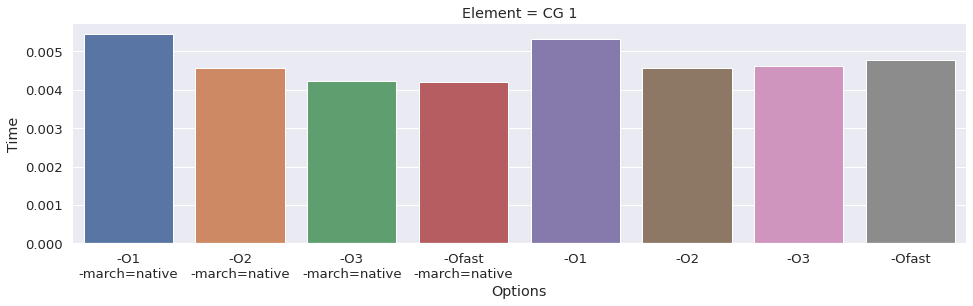

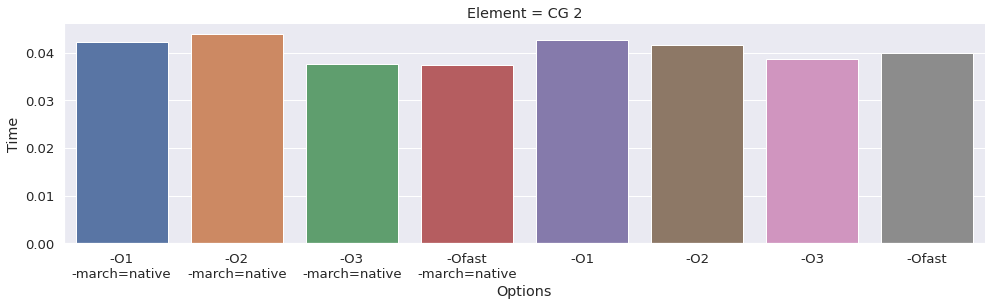

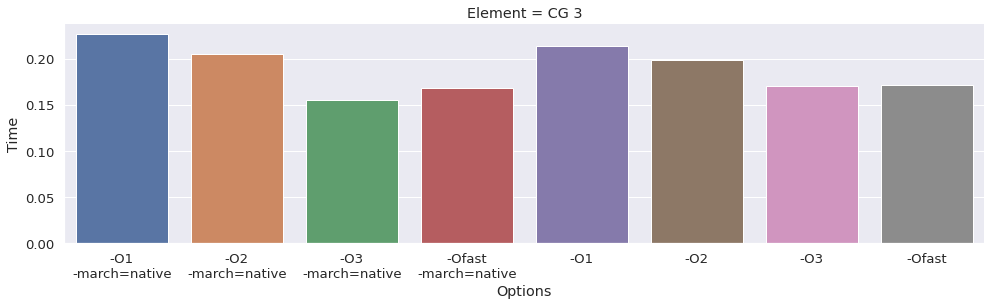

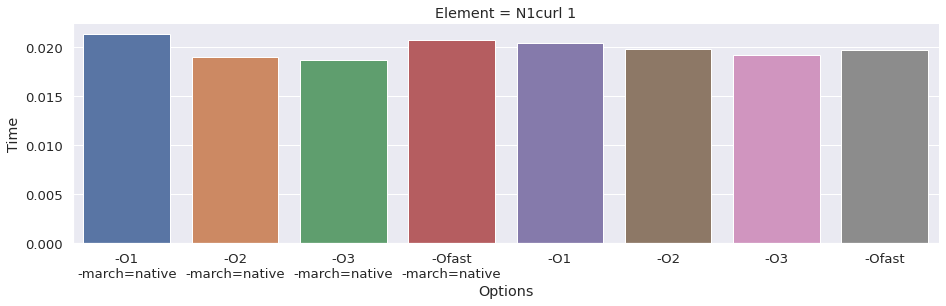

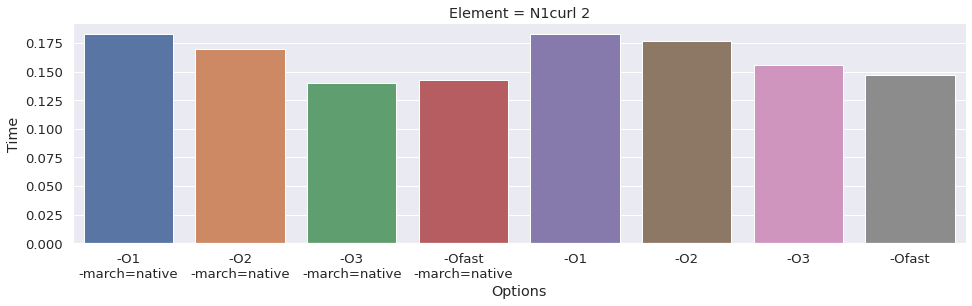

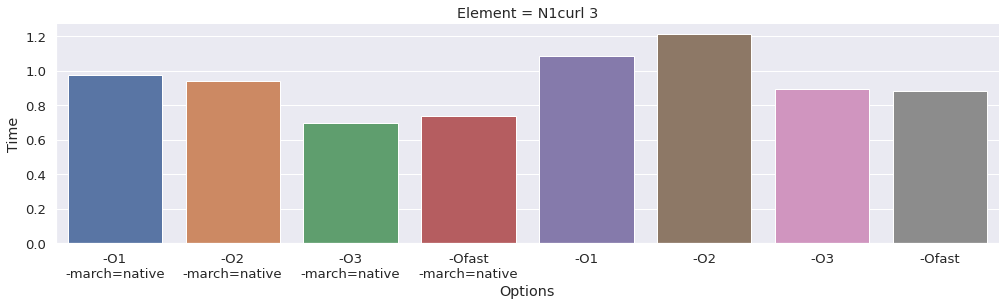

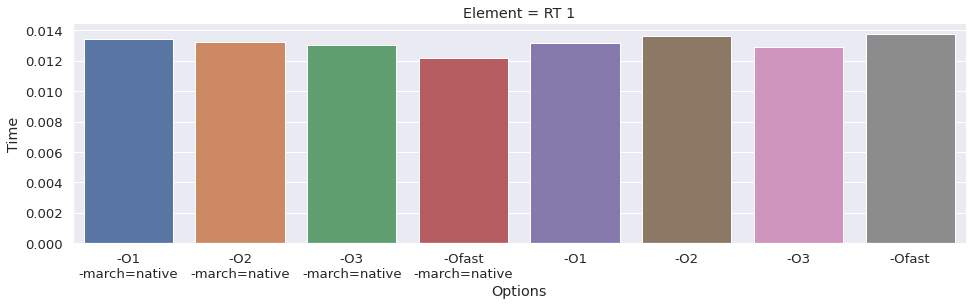

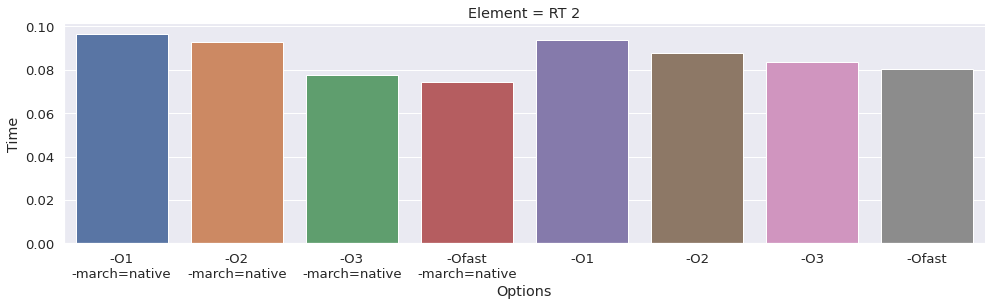

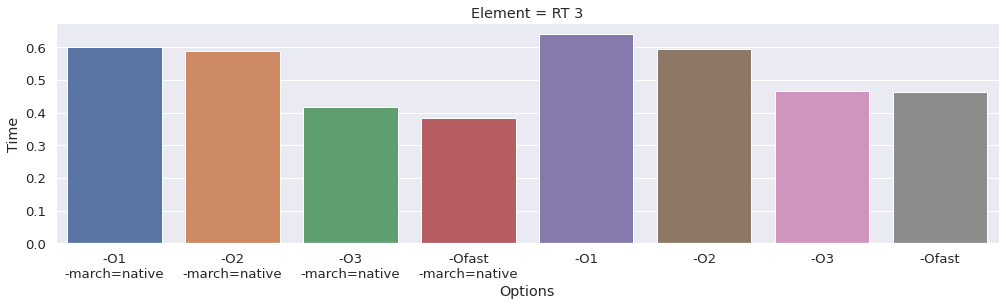

In [34]:
import seaborn
import matplotlib.pyplot as plt
seaborn.set(style="ticks")
seaborn.set(font_scale=1.2)  
seaborn.set_style("darkgrid")
results_df["Element"] = results_df["Space"]+" " + results_df["Degree"]
elements = sorted(set(results_df["Element"]))
for element in elements:
    df_e = results_df[results_df["Element"]==element]
    g = seaborn.catplot(x="Options", y="Time", kind="bar", data=df_e, col="Element")
    g.fig.set_size_inches(16,4)

We observe that the compile time increases when increasing the degree of the function space, and that we get most speedup by using "-O3" or "-Ofast" combined with "-march=native".